In [1]:
#Import Libraries
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from utils import read_yaml
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from mlflow.models import infer_signature
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlflow.data.pandas_dataset import PandasDataset
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import (roc_curve, roc_auc_score, 
                            classification_report, accuracy_score, 
                            precision_score, recall_score, 
                            f1_score)


In [100]:
train = pd.read_csv('data/train1.csv')
test = pd.read_csv('data/test1.csv')

In [101]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.333333,0.0,0.044302,0.066667,0.800000,1.000000,0.285714,0.8,1.0,0.0,0.02174,0.0,0.397959,1.0,0.0
1,0.333333,0.0,0.048238,0.066667,0.800000,0.666667,0.071429,0.2,1.0,0.0,0.00000,0.0,0.122449,1.0,0.0
2,0.333333,1.0,0.138113,0.000000,0.533333,0.333333,0.642857,0.8,1.0,0.0,0.00000,0.0,0.397959,1.0,0.0
3,0.333333,1.0,0.151068,0.866667,0.400000,0.666667,0.642857,0.2,0.0,0.0,0.00000,0.0,0.397959,1.0,0.0
4,0.000000,1.0,0.221488,0.066667,0.800000,0.666667,0.142857,0.6,0.0,1.0,0.00000,0.0,0.397959,0.0,0.0


In [102]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.000000,1.0,0.144430,0.866667,0.400000,1.000000,0.214286,1.0,0.0,0.0,0.000000,0.0,0.397959,1.0,0.0
1,0.333333,1.0,0.051677,0.000000,0.533333,0.666667,0.285714,0.2,1.0,0.0,0.000000,0.0,0.500000,1.0,0.0
2,0.000000,0.0,0.219011,0.400000,0.733333,0.666667,0.428571,0.2,1.0,0.0,0.000000,0.0,0.397959,1.0,1.0
3,0.333333,1.0,0.099418,0.133333,0.600000,0.666667,0.214286,0.2,0.0,0.0,0.076881,0.0,0.397959,1.0,1.0
4,0.000000,0.0,0.060942,0.133333,0.600000,1.000000,0.714286,1.0,1.0,1.0,0.000000,0.0,0.295918,1.0,0.0


In [103]:
#X_train = train.drop('income', axis = 1)
X_train = train.drop(['income'], axis = 1)

In [104]:
#X_test = test.drop('income', axis = 1)
X_test = test.drop(['income'], axis = 1)

In [105]:
y_train = train['income']
y_test = test['income']

In [106]:
#undersampling the train set
under = OneSidedSelection()
X_train, y_train = under.fit_resample(X_train, train['income'])


#oversampling the train set
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train, columns=train.drop(['income'], axis=1).columns)



#creating the final train 
X_train = pd.concat([X_train, y_train], axis=1)

In [107]:
X_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.333333,0.0,0.044302,0.066667,0.800000,1.000000,0.285714,0.8,1.0,0.0,0.02174,0.0,0.397959,1.0,0.0
1,0.333333,0.0,0.048238,0.066667,0.800000,0.666667,0.071429,0.2,1.0,0.0,0.00000,0.0,0.122449,1.0,0.0
2,0.333333,1.0,0.138113,0.000000,0.533333,0.333333,0.642857,0.8,1.0,0.0,0.00000,0.0,0.397959,1.0,0.0
3,0.000000,1.0,0.221488,0.066667,0.800000,0.666667,0.142857,0.6,0.0,1.0,0.00000,0.0,0.397959,0.0,0.0
4,0.333333,1.0,0.100448,1.000000,0.266667,0.333333,0.428571,0.8,0.0,1.0,0.00000,0.0,0.153061,0.0,0.0


In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45788 entries, 0 to 45787
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45788 non-null  float64
 1   workclass       45788 non-null  float64
 2   fnlwgt          45788 non-null  float64
 3   education       45788 non-null  float64
 4   education_num   45788 non-null  float64
 5   marital_status  45788 non-null  float64
 6   occupation      45788 non-null  float64
 7   relationship    45788 non-null  float64
 8   race            45788 non-null  float64
 9   sex             45788 non-null  float64
 10  capital_gain    45788 non-null  float64
 11  capital_loss    45788 non-null  float64
 12  hours_per_week  45788 non-null  float64
 13  native_country  45788 non-null  float64
 14  income          45788 non-null  float64
dtypes: float64(15)
memory usage: 5.2 MB


In [109]:
y_train = X_train['income']
X_train.drop('income', inplace=True, axis=1)#.head()

In [110]:
X_train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.333333,0.0,0.044302,0.066667,0.800000,1.000000,0.285714,0.800000,1.0,0.0,0.021740,0.0,0.397959,1.0
1,0.333333,0.0,0.048238,0.066667,0.800000,0.666667,0.071429,0.200000,1.0,0.0,0.000000,0.0,0.122449,1.0
2,0.333333,1.0,0.138113,0.000000,0.533333,0.333333,0.642857,0.800000,1.0,0.0,0.000000,0.0,0.397959,1.0
3,0.000000,1.0,0.221488,0.066667,0.800000,0.666667,0.142857,0.600000,0.0,1.0,0.000000,0.0,0.397959,0.0
4,0.333333,1.0,0.100448,1.000000,0.266667,0.333333,0.428571,0.800000,0.0,1.0,0.000000,0.0,0.153061,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45783,0.333333,1.0,0.155731,0.600000,0.466667,0.666667,1.000000,0.200000,1.0,0.0,0.076245,0.0,0.397959,1.0
45784,0.000000,0.0,0.186039,0.000000,0.533333,0.666667,1.000000,0.200000,1.0,0.0,0.000000,0.0,0.397959,1.0
45785,0.333333,1.0,0.163563,0.133333,0.600000,0.666667,1.000000,0.200000,1.0,0.0,0.000000,0.0,0.553015,1.0
45786,0.000000,1.0,0.075475,0.066667,0.800000,1.000000,0.000000,0.833453,1.0,0.0,0.000000,0.0,0.397959,1.0


In [113]:
y_train.value_counts()

0.0    22894
1.0    22894
Name: income, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45788 entries, 0 to 45787
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45788 non-null  float64
 1   workclass       45788 non-null  float64
 2   fnlwgt          45788 non-null  float64
 3   education       45788 non-null  float64
 4   education_num   45788 non-null  float64
 5   marital_status  45788 non-null  float64
 6   occupation      45788 non-null  float64
 7   relationship    45788 non-null  float64
 8   race            45788 non-null  float64
 9   sex             45788 non-null  float64
 10  capital_gain    45788 non-null  float64
 11  capital_loss    45788 non-null  float64
 12  hours_per_week  45788 non-null  float64
 13  native_country  45788 non-null  float64
dtypes: float64(14)
memory usage: 4.9 MB


In [114]:
configbox = read_yaml('params.yaml')
xgb_params = configbox.XGBOOST

yaml file: params.yaml loaded successfully


In [115]:
xgb_params

ConfigBox({'n_estimators': 128, 'learning_rate': 0.1, 'max_depth': 6})

### XGB

In [116]:
xgb_classifier = xgb.XGBClassifier(n_estimators = xgb_params.n_estimators,
                                   learning_rate = xgb_params.learning_rate,
                                  max_depth = xgb_params.max_depth)

In [117]:
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_pred_train = xgb_classifier.predict(X_train)

accuracy_train = accuracy_score(y_train, y_pred_train)
print(accuracy_train)

0.9008692233773041


In [118]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test,y_pred)

metrics = {'Precision': precision, 'Recall': recall, 'f1_score': f_score, 'AUC': auc, 'accuracy': accuracy}

In [119]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df 

,precision,recall,f1-score,support
0.0,0.928128,0.828709,0.875605,12435.000000
1.0,0.588644,0.792512,0.675532,3846.000000
accuracy,0.820158,0.820158,0.820158,0.820158
macro avg,0.758386,0.810610,0.775569,16281.000000
weighted avg,0.847933,0.820158,0.828343,16281.000000


In [120]:
print(classification_report(y_train,y_pred_train))
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     22894
         1.0       0.89      0.92      0.90     22894

    accuracy                           0.90     45788
   macro avg       0.90      0.90      0.90     45788
weighted avg       0.90      0.90      0.90     45788

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     12435
         1.0       0.59      0.79      0.68      3846

    accuracy                           0.82     16281
   macro avg       0.76      0.81      0.78     16281
weighted avg       0.85      0.82      0.83     16281



In [121]:
xgboost_auc=roc_auc_score(y_test,y_pred)
r_probs = [0 for _ in range(len(y_test))]
random_auc = roc_auc_score(y_test, r_probs)
print(xgboost_auc)
print(random_auc)

0.8106104943835872
0.5


In [122]:
probs = xgb_classifier.predict_proba(X_test)
# Keep probabilities for one class
probs = probs[:,1]

# Get false and True positive rate
r_fpr, r_tpr, _ = roc_curve(y_test,probs)
x = np.arange(0,1.01,0.01)

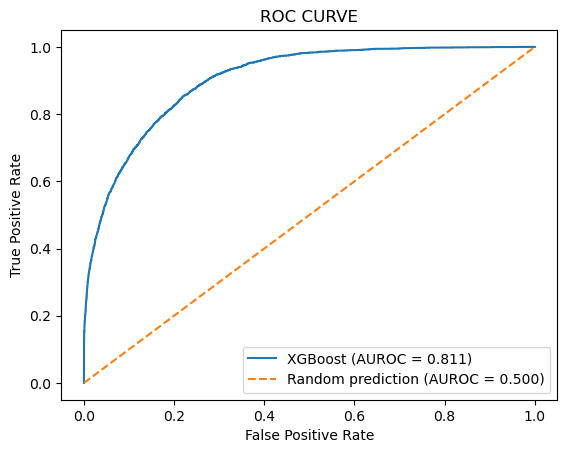

<Figure size 640x480 with 0 Axes>

In [126]:
plt.plot(r_fpr, r_tpr, label='XGBoost (AUROC = %0.3f)' % xgboost_auc)
plt.plot(x,x, linestyle='--', label='Random prediction (AUROC = %0.3f)' % random_auc)
plt.legend()
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.savefig(f'visualization/roc_curve{xgboost_auc}.png')

In [124]:
# Construct an MLflow PandasDataset from the Pandas DataFrame, and specify the source
train_dataset: PandasDataset = mlflow.data.from_pandas(train, source= 'data/train1.csv')
# test
test_dataset: PandasDataset = mlflow.data.from_pandas(test, source= 'data/test1.csv')

C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\mlflow\data\dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [125]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("XGBOOST EXPERIMENTS")

with mlflow.start_run() as run:
    mlflow.log_params(xgb_params)
    mlflow.log_metrics(metrics)
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("full columns", "undersampling and over sampling")
    
    # Log the dataset to the MLflow Run. Specify the "training" context to indicate that the
    # dataset is used for model training
    mlflow.log_input(train_dataset, context="training")
    mlflow.log_input(test_dataset, context = "testing")
    

    
    # Infer the model signature
    signature = infer_signature(X_train, y_pred_train)
    
    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model= xgb_classifier,
        artifact_path = "income_class",
        signature = signature,
        input_example = X_train,
        registered_model_name = "xgboost",
    )


C:\Users\Windows 10\.conda\envs\tensorflow_env\lib\site-packages\xgboost\core.py:160: UserWarning: [15:54:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
Registered model 'xgboost' already exists. Creating a new version of this model...
2024/03/19 15:54:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 8
Created version '8' of model 'xgboost'.


### Random Forest

In [ ]:
rf=RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
import mlflow
from mlflow.models import infer_signature

In [33]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

mlflow.set_experiment("XGBOOST EXPERIMENTS")

with mlflow.start_run() as run:
    mlflow.log_params(rf_params)
    mlflow.log_metrics(rf_metrics)
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("")
    
    # Infer the model signature
    signature = infer_signature(X_train, y_pred_train)
    
    # Log the model
    model_info = mlflow.xgboost.log_model(
        xgb_model= xgb_classifier,
        artifact_path = "income_class",
        signature = signature,
        input_example = X_train,
        registered_model_name = "random_forest",
    )


TypeError: set_tag() missing 1 required positional argument: 'value'